# Orbit Error Prediction

In [1]:
# Libraries:
import os
import math
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline

# Sci-Kit Learn Packages:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing   import PolynomialFeatures, RobustScaler
from sklearn.metrics         import mean_squared_error, r2_score

## Which Label Are We Predicting?

In [2]:
target_label = "vz"

## Data Loading

In [3]:
# Loading Data:
def load_data (data_id = "31698", coor_type = "RTN"):
    if data_id not in ["31698", "31722", "36605", "40309"]:
        raise ValueError("Invalid `data_id` value.")
    if coor_type not in ["XYZ", "RTN"]:
        raise ValueError("Invalid `coor_type` value.")
    full_dir = os.path.join("./Dataset", data_id, coor_type, "P1.csv")
    return pd.read_csv(full_dir)

df = load_data()
df.head(5)

,Unnamed: 0,Time,Delta_t,c1_x,c1_y,c1_z,c1_vx,c1_vy,c1_vz,c1_t,...,True_z,True_vx,True_vy,True_vz,Approx_x,Approx_y,Approx_z,Approx_vx,Approx_vy,Approx_vz
0,0,0.0,0.0,-6.409894,-67.908324,2.485850,0.076227,0.002874,-0.001670,-10725.092378,...,-5.906133e-11,1.975155e-13,7609.474242,-2.184792e-14,6.885180e+06,1.146216e-10,-5.906133e-11,1.975155e-13,7609.474242,-2.184792e-14
1,1,0.0,300.0,-11.912883,-178.463405,2.590256,0.198689,0.007096,0.004073,-17801.666518,...,1.112339e-03,6.896194e+00,7609.896042,-1.551917e-06,6.886238e+06,-7.042190e-11,-1.032813e-10,6.896371e+00,7609.896139,-4.783620e-14
2,2,0.0,600.0,-10.764104,-108.981466,-3.250745,0.120754,0.006927,0.001847,-13657.466810,...,-6.212991e-03,1.223649e+01,7609.745803,-5.552468e-05,6.889161e+06,3.439537e-10,-3.399776e-10,1.223686e+01,7609.745808,-4.436440e-13
3,3,0.0,900.0,0.000082,0.000121,-0.000017,-0.000008,-0.000012,0.000002,-19.441757,...,-3.641751e-02,1.517615e+01,7608.392963,-1.513020e-04,6.893338e+06,4.174392e-10,1.584281e-10,1.517665e+01,7608.392774,3.340220e-13
4,4,0.0,1200.0,-19.798722,-618.302093,6.792656,0.684463,0.007596,-0.006816,-33422.058565,...,-9.912217e-02,1.557404e+01,7605.321046,-2.681061e-04,6.898010e+06,8.383682e-11,1.652384e-10,1.557456e+01,7605.320709,2.614618e-13


## Error Visualisation

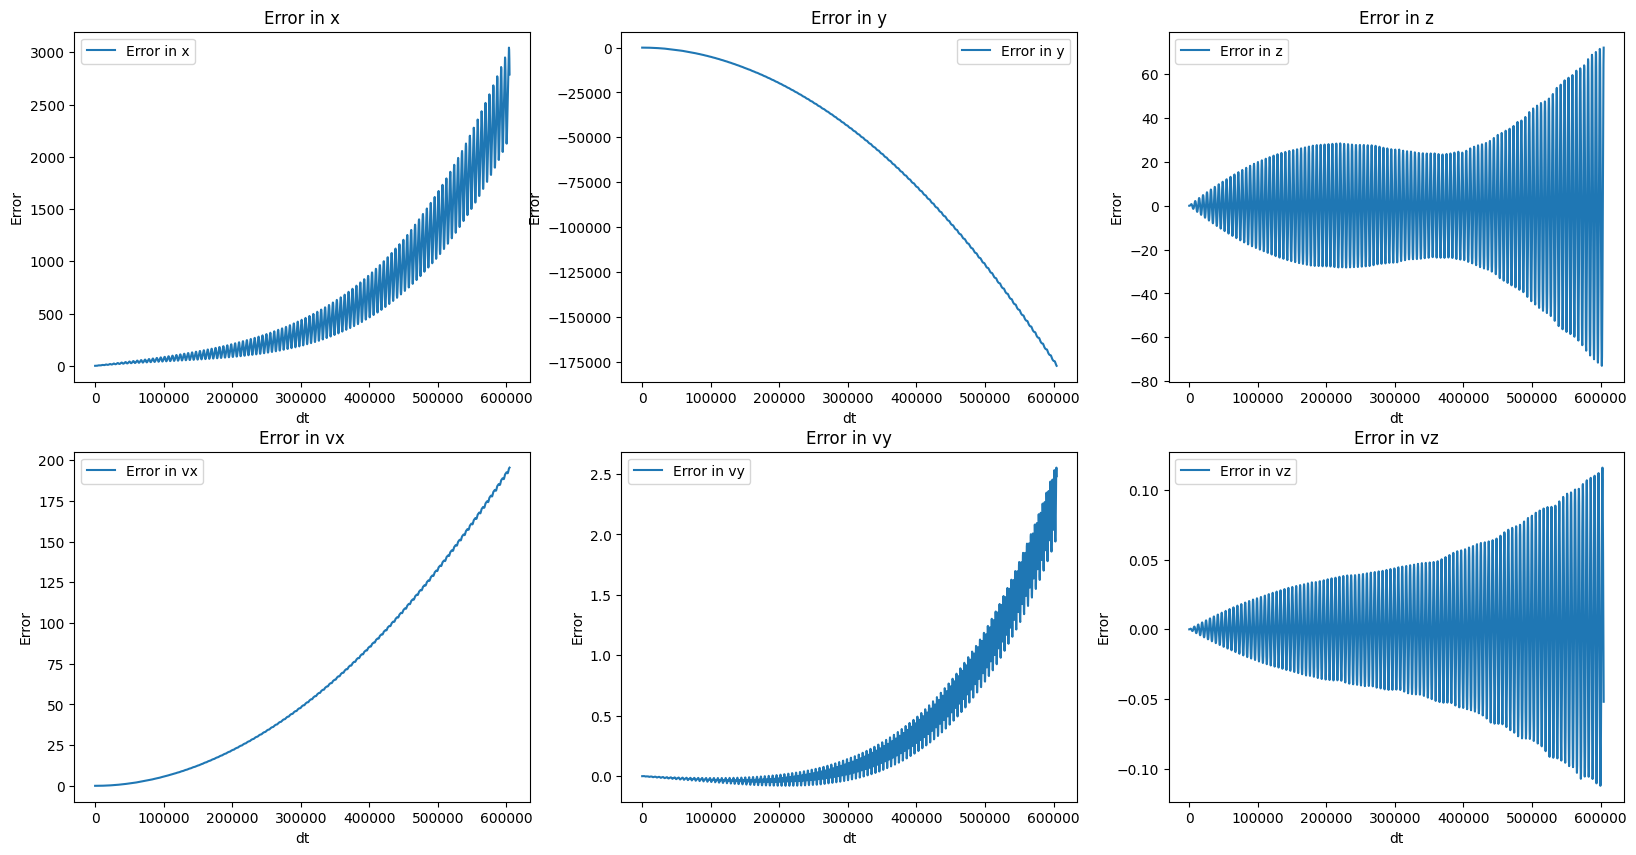

In [4]:
def plot_errors (df = df, target_time = 0.0):
    if target_time not in df["Time"].unique():
        raise ValueError("Invalid `target_time` value.")
    # Filter by `Time` = target_time.
    df_filter = df[df["Time"] == target_time]
    # Create subplots.
    fig, axs = plt.subplots(2, 3, figsize = (20, 10))
    # Plot differences:
    for idx, coord in enumerate(["x", "y", "z", "vx", "vy", "vz"]):
        true_val = "True_" + coord
        pred_val = "Approx_" + coord
        ax = axs[idx // 3, idx % 3]
        ax.plot(
            df_filter["Delta_t"], df_filter[pred_val] - df_filter[true_val],
            label = "Error in " + coord
        )
        ax.set_xlabel("dt")
        ax.set_ylabel("Error")
        ax.set_title("Error in " + coord)
        ax.legend()
    plt.show()

plot_errors()

## Pre-Processing Stream

In [5]:
def create_error_columns (df):
    for coord in ["x", "y", "z"]:
        # Create Error Columns:
        # 1: For Position
        true_pos = "True_" + coord
        pred_pos = "Approx_" + coord
        error_pos = "Error_" + coord
        df[error_pos] = df[pred_pos] - df[true_pos]
        # 2: For Velocity
        true_vel = "True_v" + coord
        pred_vel = "Approx_v" + coord
        error_vel = "Error_v" + coord
        df[error_vel] = df[pred_vel] - df[true_vel]
        # Drop `True` and `Approx` Columns:
        # 1: For Position
        df.drop(true_pos, axis = "columns", inplace = True)
        df.drop(pred_pos, axis = "columns", inplace = True)
        # 2: For Velocity
        df.drop(true_vel, axis = "columns", inplace = True)
        df.drop(pred_vel, axis = "columns", inplace = True)
    return df

def filter_data_by_label (df, target_label = "x", variables = "all"):
    if target_label not in ["x", "y", "z", "vx", "vy", "vz"]:
        raise ValueError("Invalid `target_label` value.")
    # Select Columns:
    target_columns = ["Time", "Delta_t"]
    for counter in range(1, 5 + 1):
        if variables == "all":
            elements = ["x", "y", "z", "vx", "vy", "vz", "t"]
        elif variables == "few":
            elements = [ target_label ]
        for element in elements:
            target_columns.append("c" + str(counter) + "_" + element)
    return df[target_columns], df["Error_" + target_label]
    
def group_train_test_split (X, y, group_factor = "Time"):
    groups = X[group_factor]
    gss = GroupShuffleSplit(
        n_splits = 1, test_size = 0.2, random_state = 42
    )
    for i, (train_index, test_index) in enumerate(gss.split(X, y, groups)):
        X_train = X.iloc[train_index]; X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]; y_test = y.iloc[test_index]
    return X_train, y_train, X_test, y_test

def pre_process (X_train, X_test, n_clusters = 2, poly = True, factor = 2):
    scaler = RobustScaler()
    X_train_norm = scaler.fit_transform(X_train)
    X_test_norm = scaler.transform(X_test)
    if poly and factor is not None:
        poly = PolynomialFeatures(factor)
        X_train = poly.fit_transform(X_train)
        X_test = poly.transform(X_test)
    return X_train_norm, X_test_norm
    
def display_predictions(X_test, y_test, predictions, scatter = True, ax = None, title = None):
    if ax is None:
        fig = plt.figure()
        ax = plt.gca()        
    if scatter:
        ax.scatter(X_test["Delta_t"], y_test, label = "Real Error")
        ax.scatter(X_test["Delta_t"], predictions, label = "Predicted Error")
    else:
        ax.plot(X_test["Delta_t"], y_test, label = "Real Error")
        ax.plot(X_test["Delta_t"], predictions, label = "Predicted Error")
    ax.set_xlabel("Time-Step")
    ax.set_ylabel("Absolute Error")
    ax.legend()
    if title is not None:
        ax.set_title(title)

def data_pipeline (df, target_label = "x", poly = True, factor = 2):
    # Remove `Unnamed: 0` Column:
    df.drop("Unnamed: 0", axis = "columns", inplace = True)
    # Create Error Columns:
    df = create_error_columns (df)
    # Select Relevant Features:
    X, y = filter_data_by_label (df, target_label)
    # Create Training, Testing, and Validation Data:
    X_train, y_train, X_test, y_test = group_train_test_split(X, y)
    # Polynomial Fitting + Feature Scaling:
    X_train_norm, X_test_norm = pre_process(X_train, X_test, poly = poly, factor = factor)
    return X_train_norm, y_train, X_test_norm, y_test, X_test

## XGBoost Regressor

In [6]:
df = load_data()
X_train_norm, y_train, X_test_norm, y_test, X_test = data_pipeline(df, target_label = target_label)

model = xgb.XGBRegressor()
model.fit(X_train_norm, y_train)
predictions = model.predict(X_test_norm)

rmse = math.sqrt(mean_squared_error(predictions, y_test))
print(f"XGBoost Regressor RMSE: {rmse:.2f} metres.")

XGBoost Regressor RMSE: 0.08 metres.


## Results:

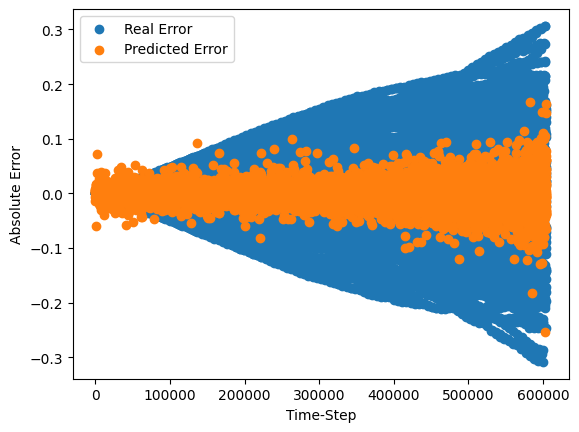

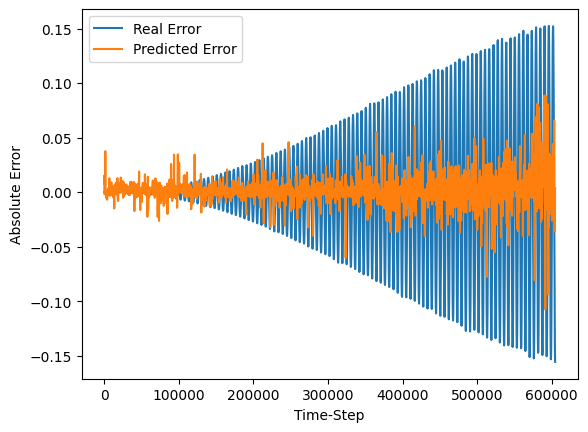

In [7]:
# All Objects:
display_predictions (X_test, y_test, predictions, scatter = True, ax = None)
# Single Object:
display_predictions (X_test[:2016], y_test[:2016], predictions[:2016], scatter = False, ax = None)

## Error Analysis:

On average, the predictions deviate from the actual values by 161623.30% of what the actual values typically are.
During the last day, the average error was of  0.00 metres.
[R2] The model explains -0.05 of the variability.


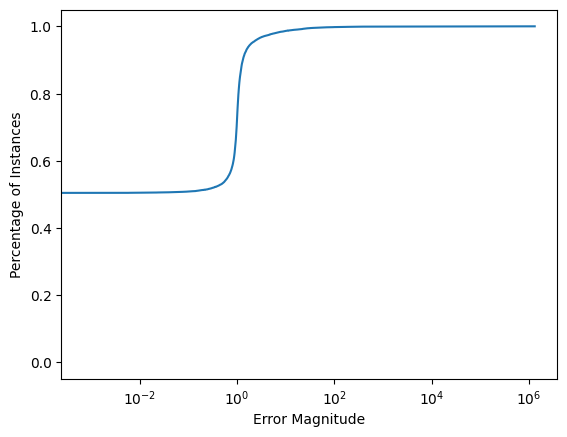

In [8]:
errors = pd.DataFrame(data = {
    "Actual": y_test,
    "Prediction": predictions
})

# Deviation Analysis:
deviation = (rmse / np.mean(errors["Actual"])) * 100
print(f"On average, the predictions deviate from the actual values by {deviation:.2f}% of what the actual values typically are.")

# Last Day Error:
error_last_day = errors.tail(2016).mean()
error_last_day = error_last_day["Actual"] - error_last_day["Prediction"]
print(f"During the last day, the average error was of { abs(error_last_day) : .2f} metres.")

# R2-Score:
r2_val = r2_score(y_test, predictions)
print(f"[R2] The model explains {r2_val :.2f} of the variability.")

# ROC:
y_test[y_test == 0] = 1e-8
sorted_error = np.sort(np.abs(y_test - predictions) / y_test)
cum_freq = np.arange(1, len(sorted_error) + 1) / len(sorted_error)

# Create Figure:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(sorted_error, cum_freq)
ax.set_xscale("log")
ax.set_xlabel("Error Magnitude")
ax.set_ylabel("Percentage of Instances")
plt.show()

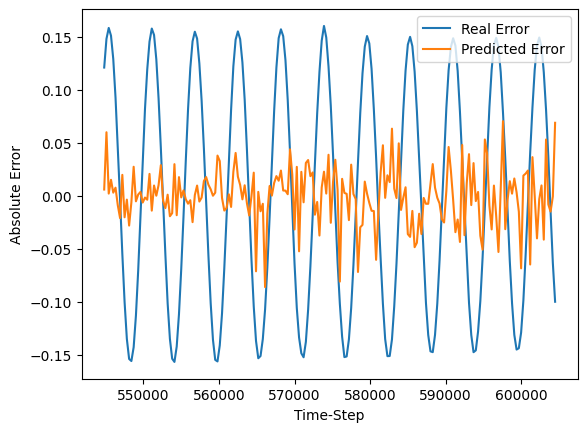

In [9]:
str_idx = X_test.shape[0] - 200
end_idx = X_test.shape[0]

display_predictions (X_test[str_idx:end_idx], y_test[str_idx:end_idx], predictions[str_idx:end_idx], scatter = False)

## Save Weights:

In [10]:
weights_dir = "Weights"
if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)

model.save_model(os.path.join(weights_dir, "weights_" + target_label))

## Test Models on New Orbit:

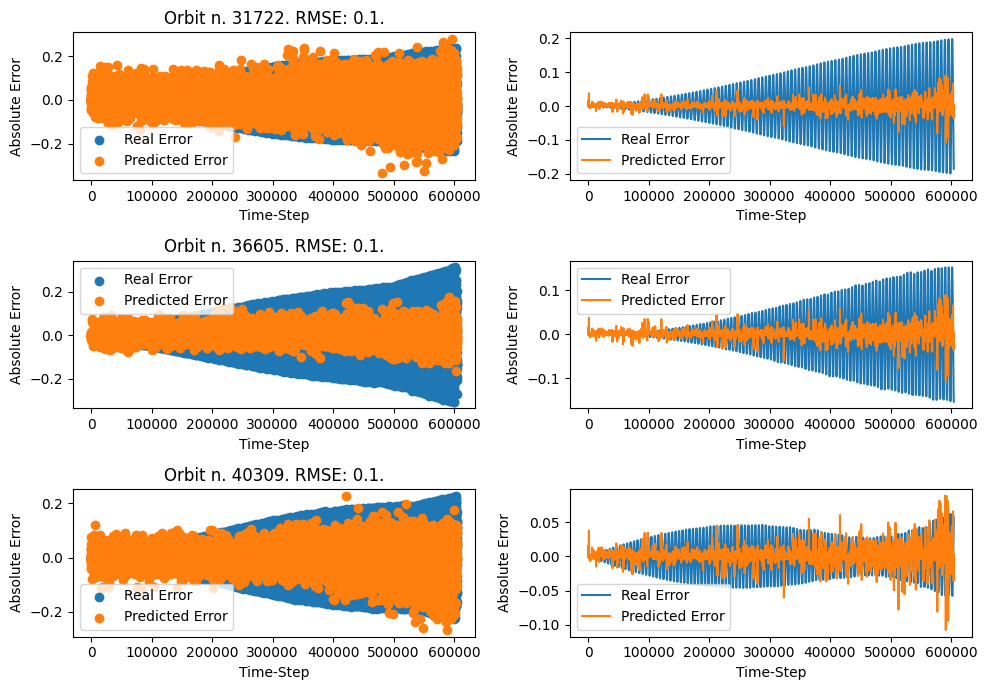

In [11]:
fig, axs = plt.subplots(3, 2, figsize = (10, 7))
orbit_numbers = ["31722", "36605", "40309"]

for idx, orbit_number in enumerate(orbit_numbers):
    # print("=" * 20 + " Results for " + orbit_number + ":")
    df_new_orbit = load_data (data_id = orbit_number, coor_type = "RTN")
    
    # Pre-Process Data:
    X_train_norm, y_train, X_test_norm, y_test, X_test = data_pipeline(
        df_new_orbit,
        target_label = target_label
    )
    
    # Load Model:
    new_model = xgb.XGBRegressor()
    new_model.load_model(os.path.join(weights_dir, "weights_" + target_label))
    
    # Make Predictions:
    new_predictions = new_model.predict(X_test_norm)
    rmse = math.sqrt(mean_squared_error(new_predictions, y_test))
    # print(f"XGBoost Regressor RMSE: {rmse:.2f} metres.")
    
    # Display Errors:
    
    # All Objects:
    display_predictions(
        X_test, y_test, new_predictions, scatter = True, ax = axs[idx, 0],
        title = "Orbit n. " + orbit_number + ". RMSE: " + str(round(rmse, 1)) + "."
    )

    # Single Object:
    display_predictions (X_test[:2016], y_test[:2016], predictions[:2016], scatter = False, ax = axs[idx, 1])


plt.tight_layout()
plt.show()